In [1]:
"""demo: a contextual evidence integration task 
"""
import time
import torch
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

from envs import ContextualChoiceTask
from models import DNDLSTM as Agent
from models.utils import get_init_states, entropy
from models.DND import compute_similarities
from models import pick_action, get_reward, compute_returns, compute_a2c_loss
from sklearn.decomposition import PCA
from scipy.stats import sem

sns.set(style='white', context='talk', palette='colorblind')
seed_val = 0
torch.manual_seed(seed_val)
np.random.seed(seed_val)

In [2]:
# gen training set
# n time steps of a trial
T = 10
# after `tp_corrupt`, turn off the noise
t_noise_off = 5
# input/output/hidden/memory dim
vec_dim = 16
task = ContextualChoiceTask(vec_dim=vec_dim, T=T, t_noise_off=t_noise_off)

# num unique training examples in one epoch
M = 30
X, K, Y = task.gen_data(M)
trial_len, _, dim_input = X.size()
# from scipy.spatial import distance_matrix
# ks = np.array([X[m, 0, :].numpy() for m in range(M)])
# sns.heatmap(-distance_matrix(ks, ks), cmap='viridis')

# X, K, Y = gen_data(vec_dim, T, M, t_noise_off)
print(f'X.size: {X.size()}, M x T x V x dummy_dim')
print(f'K.size: {K.size()}, M x T x V x dummy_dim')
print(f'Y.size: {Y.size()}, M x T x V x dummy_dim')

X.size: torch.Size([60, 10, 32]), M x T x V x dummy_dim
K.size: torch.Size([60, 10, 16]), M x T x V x dummy_dim
Y.size: torch.Size([60, 10]), M x T x V x dummy_dim


In [4]:
# set params
n_hidden = 16
dim_hidden = n_hidden
dim_output = 2
dict_len = 50
learning_rate = 1e-3
n_epochs = 10
eta = 0

# init model and hidden state.
agent = Agent(dim_input, dim_hidden, dim_output, dict_len)
optimizer = torch.optim.Adam(agent.parameters(), lr=learning_rate)

In [5]:
'''train'''
log_return = np.zeros(n_epochs,)
log_ent = np.zeros(n_epochs,)
log_loss_value = np.zeros(n_epochs,)
log_loss_policy = np.zeros(n_epochs,)

log_Y = np.zeros((n_epochs, trial_len, T))
log_Y_hat = np.zeros((n_epochs, trial_len, T))
log_rgate = np.zeros((trial_len, T, dim_hidden))

# loop over epoch
for i in range(n_epochs):
    time_start = time.time()
    # get data for this epoch
    X, K, Y = task.gen_data(M)
    # flush hippocampus
    agent.dnd.reset_memory()
    agent.turn_on_retrieval()

    # loop over the training set
    for m in range(trial_len):
        x_m, y_m, k_m = X[m], Y[m], K[m]
        # prealloc
        cumulative_reward = 0
        cumulative_entropy = 0
        probs, rewards, values = [], [], []
        h_t, c_t = get_init_states(dim_hidden)

        # loop over time, for one training example
        for t in range(T):
            # only save memory at the last time point
            agent.turn_off_encoding()
            if t == T-1 and m < M:
                agent.turn_on_encoding()
            # recurrent computation at time t
            outputs_ = agent(x_m[t].view(1, 1, -1), h_t, c_t)
            pi_a_t, v_t, h_t, c_t, cache_t = outputs_
            # action selection
            a_t, prob_a_t = pick_action(pi_a_t)
            # compute immediate reward
            r_t = get_reward(a_t, y_m[t])
            # compute response entropy
            cumulative_entropy += entropy(pi_a_t)
            # log
            probs.append(prob_a_t)
            rewards.append(r_t)
            values.append(v_t)
            # log
            cumulative_reward += r_t
            log_Y_hat[i, m, t] = a_t.item()
            [f_t, i_t, o_t, r_t, m_t] = cache_t
            log_rgate[m, t] = np.squeeze(r_t.data.numpy())

        returns = compute_returns(rewards)
        loss_policy, loss_value = compute_a2c_loss(probs, values, returns)
        loss = loss_policy + loss_value - eta * cumulative_entropy
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        # log
        log_Y[i] = Y.numpy()
        log_ent[i] = cumulative_entropy / trial_len
        log_return[i] += cumulative_reward / trial_len
        log_loss_value[i] += loss_value.item() / trial_len
        log_loss_policy[i] += loss_policy.item() / trial_len

    # print out some stuff
    time_end = time.time()
    run_time = time_end - time_start
    print(
        'Epoch %3d | return = %.2f, ent = %.2f | loss: val = %.2f, pol = %.2f | time = %.2f' %
        (i, log_return[i], log_ent[i],
         log_loss_value[i], log_loss_policy[i], run_time)
    )

Epoch   0 | return = 5.27, ent = 0.13 | loss: val = 3.10, pol = 3.71 | time = 0.69
Epoch   1 | return = 6.47, ent = 0.13 | loss: val = 1.41, pol = 0.10 | time = 0.73
Epoch   2 | return = 7.02, ent = 0.13 | loss: val = 1.13, pol = -0.67 | time = 0.67
Epoch   3 | return = 7.43, ent = 0.07 | loss: val = 0.90, pol = -1.26 | time = 0.65
Epoch   4 | return = 7.37, ent = 0.09 | loss: val = 0.86, pol = -0.73 | time = 0.64
Epoch   5 | return = 7.32, ent = 0.09 | loss: val = 0.88, pol = -0.67 | time = 0.65
Epoch   6 | return = 7.90, ent = 0.10 | loss: val = 0.76, pol = -0.76 | time = 0.65
Epoch   7 | return = 7.70, ent = 0.02 | loss: val = 0.82, pol = -0.66 | time = 0.68
Epoch   8 | return = 8.28, ent = 0.03 | loss: val = 0.68, pol = -0.38 | time = 0.66
Epoch   9 | return = 7.82, ent = 0.05 | loss: val = 0.74, pol = -0.65 | time = 0.67


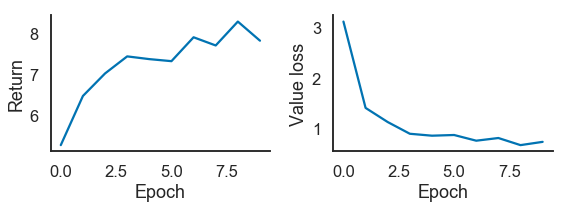

In [6]:
f, axes = plt.subplots(1, 2, figsize=(8, 3))
axes[0].plot(log_return)
axes[0].set_ylabel('Return')
axes[0].set_xlabel('Epoch')
axes[1].plot(log_loss_value)
axes[1].set_ylabel('Value loss')
axes[1].set_xlabel('Epoch')
sns.despine()
f.tight_layout()

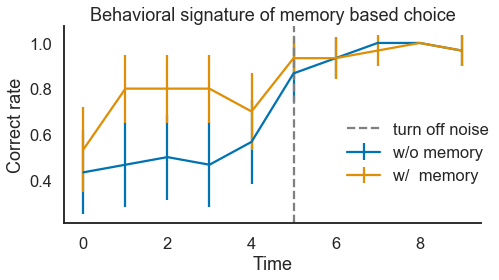

In [7]:
'''analysis'''

n_se = 2
# compute stat
corrects = log_Y_hat[-1] == log_Y[-1]
mu_mem0 = np.mean(corrects[:M], axis=0)
er_mem0 = sem(corrects[:M], axis=0) * n_se
mu_mem1 = np.mean(corrects[M:], axis=0)
er_mem1 = sem(corrects[M:], axis=0) * n_se

f, ax = plt.subplots(1, 1, figsize=(7, 4))
ax.errorbar(range(T), y=mu_mem0, yerr=er_mem0, label='w/o memory')
ax.errorbar(range(T), y=mu_mem1, yerr=er_mem1, label='w/  memory')
ax.axvline(t_noise_off, label='turn off noise', color='grey', linestyle='--')
ax.set_xlabel('Time')
ax.set_ylabel('Correct rate')
ax.set_title('Behavioral signature of memory based choice')
f.legend(frameon=False, bbox_to_anchor=(1, .6))
sns.despine()
f.tight_layout()

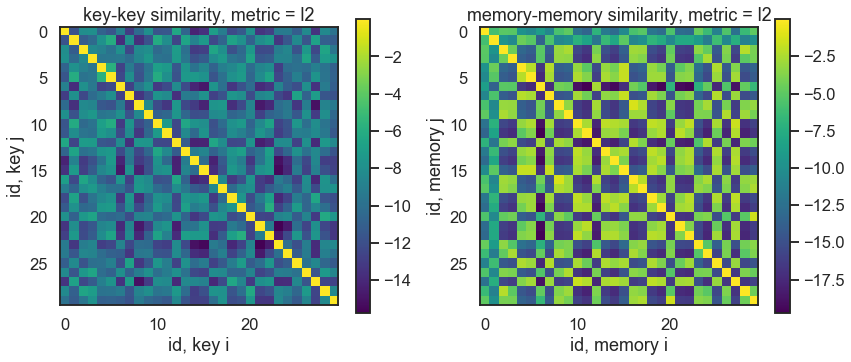

In [8]:
'''visualize keys and values'''
dmat_mm = np.zeros((len(agent.dnd.keys), len(agent.dnd.keys)))
dmat_kk = np.zeros((len(agent.dnd.keys), len(agent.dnd.keys)))

for i in range(len(agent.dnd.keys)):
    for j in range(len(agent.dnd.keys)):
        dmat_mm[i, j] = compute_similarities(
            agent.dnd.vals[i], [agent.dnd.vals[j]], agent.dnd.kernel
        ).item()
        dmat_kk[i, j] = compute_similarities(
            agent.dnd.keys[i], [agent.dnd.keys[j]], agent.dnd.kernel
        ).item()

# plot
dmats = [dmat_kk, dmat_mm]
labels = ['key', 'memory']

f, axes = plt.subplots(1, 2, figsize=(12, 5))
for i, ax in enumerate(axes):
    im = ax.imshow(dmats[i], cmap='viridis')
    f.colorbar(im, ax=ax)
    ax.set_xlabel(f'id, {labels[i]} i')
    ax.set_ylabel(f'id, {labels[i]} j')
    ax.set_title(
        f'{labels[i]}-{labels[i]} similarity, metric = {agent.dnd.kernel}')
f.tight_layout()

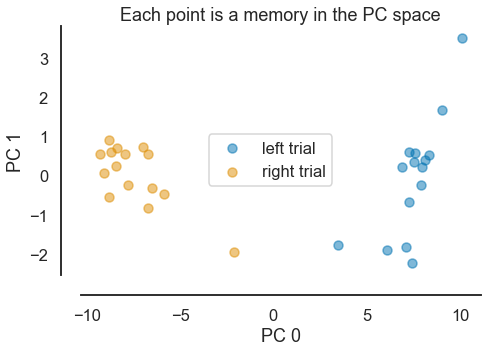

In [10]:
# organize the values to a numpy array, #memories x mem_dim
all_keys = np.vstack(
    [agent.dnd.keys[i].data.numpy() for i in range(len(agent.dnd.keys))])
all_vals = np.vstack(
    [agent.dnd.vals[i].data.numpy() for i in range(len(agent.dnd.vals))])
all_ys = Y[:M, 0].numpy()

# embed the memory to PC space
pca = PCA(n_components=10)
all_vals_pca = pca.fit_transform(all_vals)
# pick pcs
pc_x = 0
pc_y = 1

# plot
f, ax = plt.subplots(1, 1, figsize=(7, 5))
for y_val in np.unique(all_ys):
    y_mask = all_ys == y_val
    ax.scatter(
        all_vals_pca[y_mask, pc_x],
        all_vals_pca[y_mask, pc_y],
        marker='o', alpha=.5,
    )
ax.set_title(f'Each point is a memory in the PC space')
ax.set_xlabel(f'PC {pc_x}')
ax.set_ylabel(f'PC {pc_y}')
ax.legend(['left trial', 'right trial'], bbox_to_anchor=(.65, .6))
sns.despine(offset=20)
f.tight_layout()
# f.savefig('../figs/pc-v.png', dpi=100, bbox_inches='tight')

# f, ax = plt.subplots(1, 1, figsize=(6, 4))
# ax.plot(np.cumsum(pca.explained_variance_ratio_))
# ax.set_title('cumulative variance explained')
# ax.set_xlabel('#PCs')
# ax.set_ylabel('% var explained')
# sns.despine()
# f.tight_layout()

In [11]:
# mean_rgate = np.mean(log_rgate, axis=-1)

# n_se = 2
# mu_mem0 = np.mean(mean_rgate[:M], axis=0)
# er_mem0 = sem(mean_rgate[:M], axis=0) * n_se
# mu_mem1 = np.mean(mean_rgate[M:], axis=0)
# er_mem1 = sem(mean_rgate[M:], axis=0) * n_se

# f, ax = plt.subplots(1, 1, figsize=(7, 4))
# ax.errorbar(range(T), y=mu_mem0, yerr=er_mem0, label='trials w/o memory')
# ax.errorbar(range(T), y=mu_mem1, yerr=er_mem1, label='trials w/  memory')
# ax.axvline(t_noise_off, label='turn off noise', color='grey', linestyle='--')
# ax.set_xlabel('Time')
# ax.set_ylabel(r'$r_t$    ', rotation=0)
# ax.set_title('Average r gate value')
# f.legend(frameon=False, bbox_to_anchor=(1, .8))
# sns.despine()
# f.tight_layout()